<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab/blob/master/RSNA_DL_Lab_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks for Medical Imaging
#### Copyright (C) 2019 Bradley J Erickson, Jason Cai, David Vogelsang
#### Mayo Clinic Radiology Informatics Lab

This notebook provides an introduction to Generative Adversarial Networks (GANs), beginning with 1D patterns. The user should feel free to experiment with adjusting parameters of the patterns provided, and also creating new patterns. By using 1D, the GAN learning is much faster than with 2D images.

The middle section of this notebook is a GAN to create T1-weighted MR images of the head, but T2-weighted and post-contrast images are also loaded, and the user should try switching as well as including all 3 types.

The final section includes an implementation of pix2pix which performs 'style transfer'. Style transfer GANs learn how one class of images looks and then converts an input image to have that same style. In our case, we will train a GAN to convert a T1-weighted MRI into a T2-weighted MRI. 

In [0]:
# Cell 1 . Load the libraries we need
%tensorflow_version 1.x

from keras.models import Model, Sequential
from keras.layers import  Dense, Input, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
#from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout



import numpy as np
import numpy.random
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from scipy import signal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot

import os, fnmatch, imageio
import nibabel as nib




%matplotlib inline

Using TensorFlow backend.


In [0]:
# Cell 2  Here we create the discriminator, generator, and the GAN

opt = Adam(lr=0.0002, beta_1=0.5)

def create_discriminator():
    inputs = Input(shape=(2,))
    d1 = Dense(50, kernel_initializer='he_uniform')(inputs)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(100, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(200, kernel_initializer='he_uniform')(d1)
    d1 = BatchNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(100, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(50, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    outputs = Dense(1, activation='sigmoid')(d1)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def create_generator(latent_dim, n_outputs=2):
    inputs = Input(shape=(latent_dim,))
    d1 = Dense(50, kernel_initializer='he_uniform')(inputs)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(100, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(200, kernel_initializer='he_uniform')(d1)
    d1 = BatchNormalization()(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(100, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    d1 = Dense(50, kernel_initializer='he_uniform')(d1)
    d1 = LeakyReLU(alpha=0.2)(d1)
    # note we use linear for the generator, though not for discriminator or GAN
    outputs = Dense(2, activation='linear')(d1)
    model = Model(inputs = inputs, outputs = outputs)
    return model

# define the combined generator and discriminator model, for updating the generator
def create_GAN(generator, discriminator):
    # make weights in the discriminator not trainable so that it doesn't learn when the generator is learning
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
#Cell 3
MIN_RANGE = -5
MAX_RANGE = 5

# we will have the GAN learn 5 different 1D functions
# we use 1D just to reduce compute time
# later we will move to images
def generate_real_1D(n, function):
    X1 = np.linspace(MIN_RANGE, MAX_RANGE, n)
    if function == 1:
        X2 = np.sin(X1)
    elif function == 2:
        X2 = signal.square(X1,0.5)
    elif function == 3:
        X2 = X1 * X1
    elif function == 4:
        X2 = signal.sawtooth(X1,0.5)
    elif function == 5:
        #circle
        theta = np.linspace(0, 2*np.pi, n)
        X1 = np.cos(theta)
        X2 = np.sin(theta)

    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.ones((n, 1))
    return X, y

# this is to give the generator some randomness for generating its examples
def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# this actually creates the fake examples
def generate_fake_1D(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    return X, y

# Show how our system is learning
def summarize_performance(generator, latent_dim, n, function):
    x_real, y_real = generate_real_1D(n, function)
    x_fake, y_fake = generate_fake_1D(generator, latent_dim, n)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.scatter(x_real[:, 0], x_real[:, 1], color='red')
    ax1.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')

    X1f = x_fake[:,0]
    X2f = x_fake[:,1]
# compute the values for the funciton but don't add error until find out if in X range
# Note also that this error is NOT the error that the discriminator is likely to be learning
    if function == 1:
        X2c = np.sin(X1f)
    elif function == 2:
        X2c = signal.square(X1f,0.5)
    elif function == 3:
        X2c = X1f * X1f
    elif function == 4:
        X2c = signal.sawtooth(X1f,0.5)
    elif function == 5:
        #since radius = 1, it is just absolute value of (cirlce equation (sqrt(x^2+y^2)) - radius
        X2c = abs(np.sqrt(X1f*X1f + X2f*X2f) - 1)

    sum_err = 0.0
    for i in range(len(X2f)):
    # first, check if X value is out of range and add error if it is
        if X1f[i] < MIN_RANGE:
            sum_err += abs(X1f[i] - MIN_RANGE)
        elif X1f[i] > MAX_RANGE:
            sum_err += abs(X1f[i] - MAX_RANGE)
    # if x in range, then compute abs error
        else:
            sum_err += abs(X2c[i] - X2f[i])

    return sum_err, ax2, fig








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


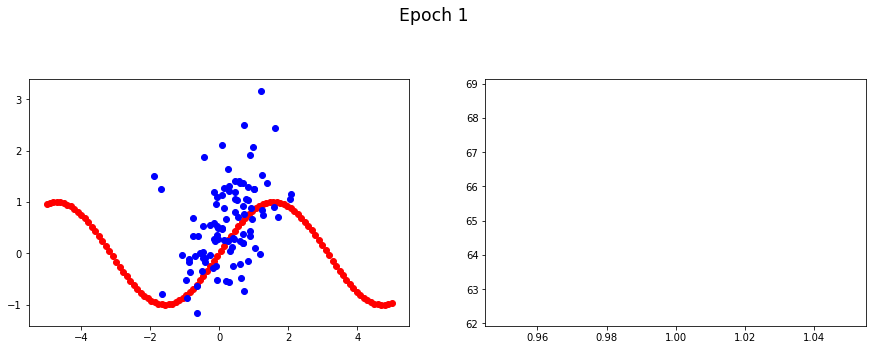

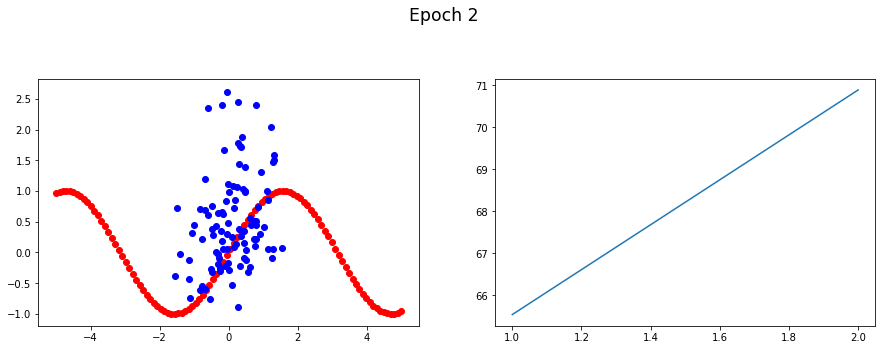

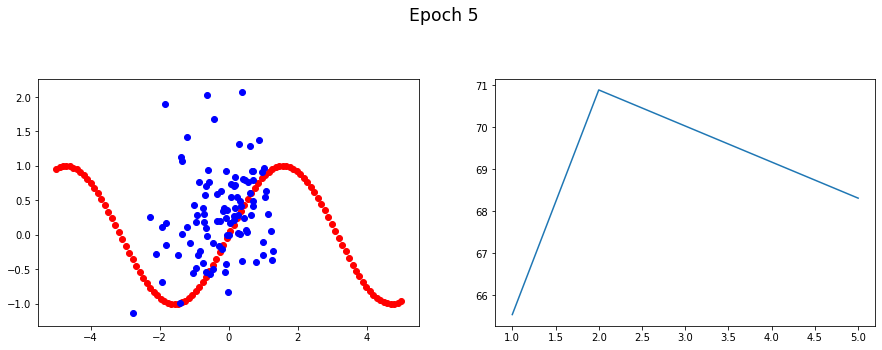

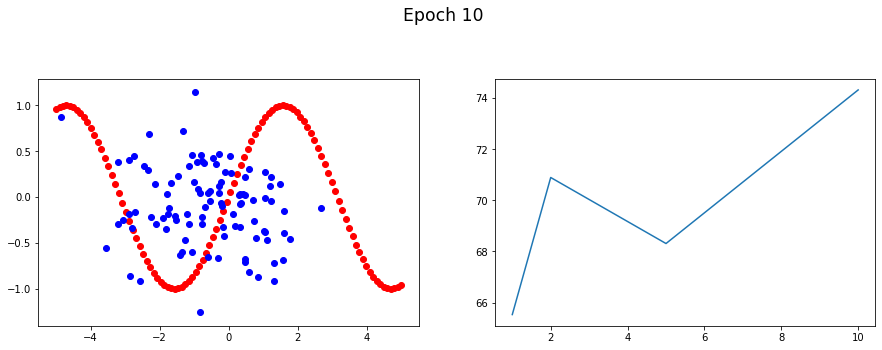

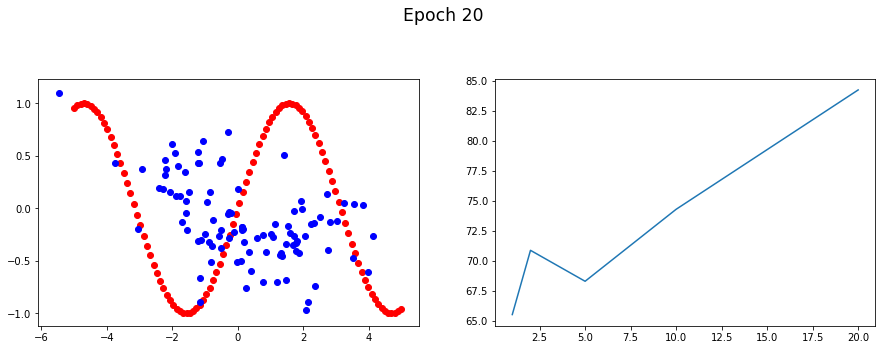

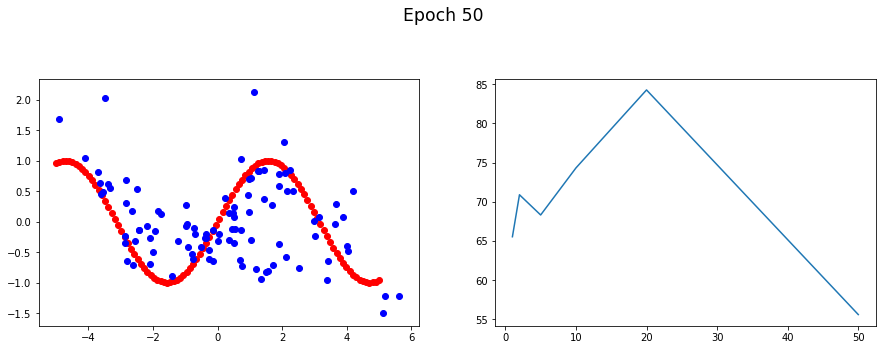

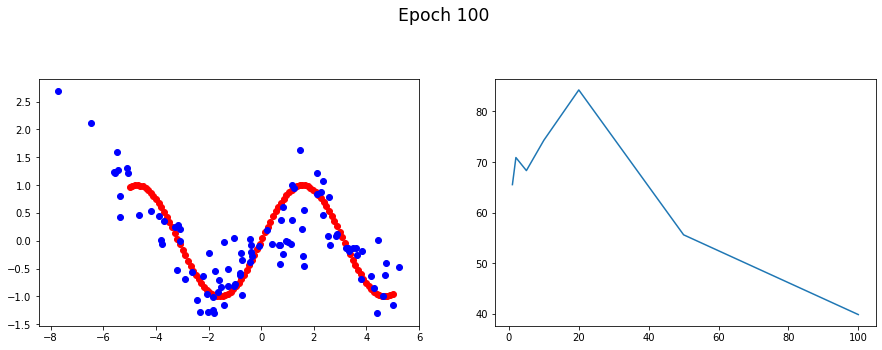

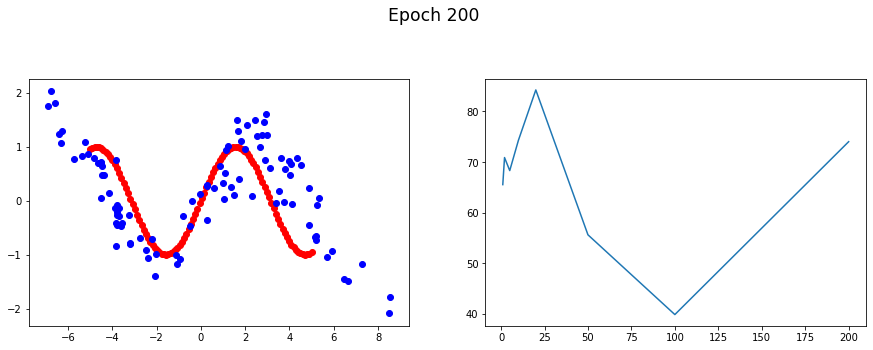

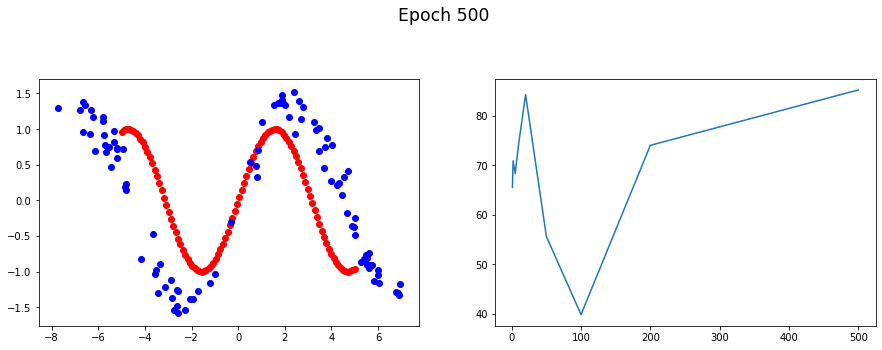

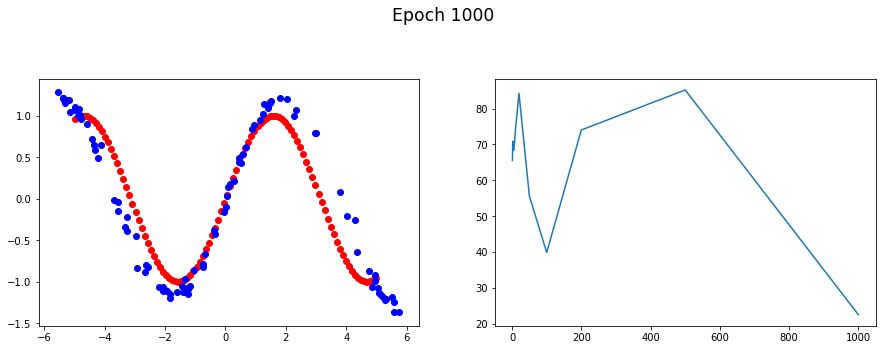

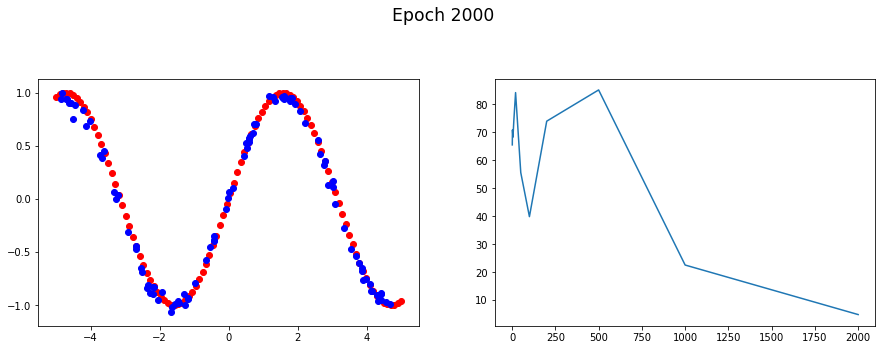

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


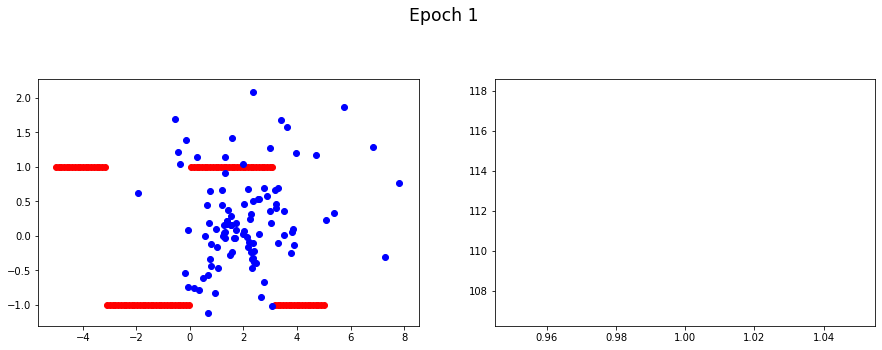

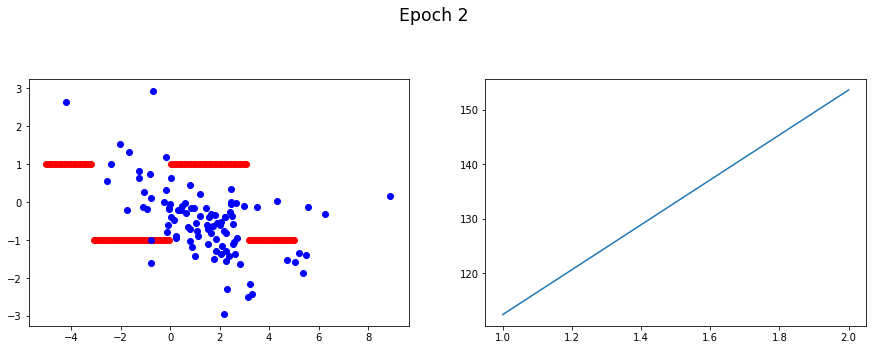

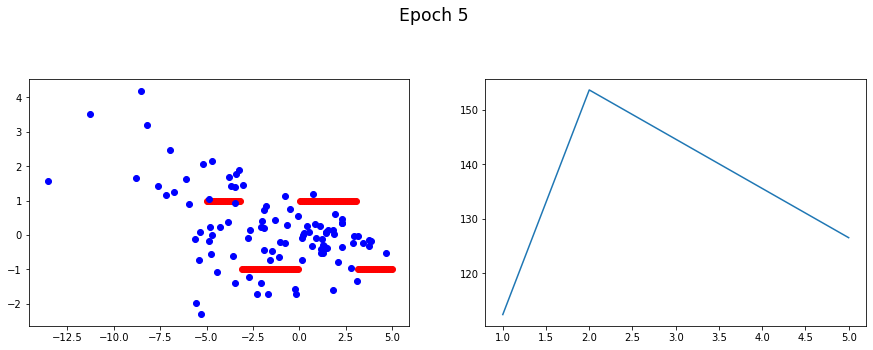

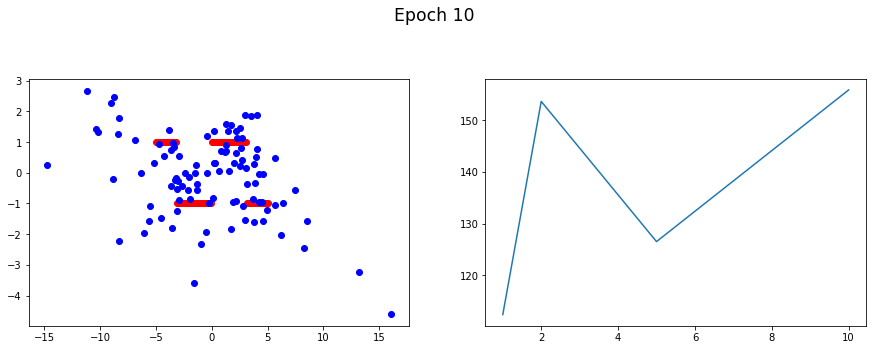

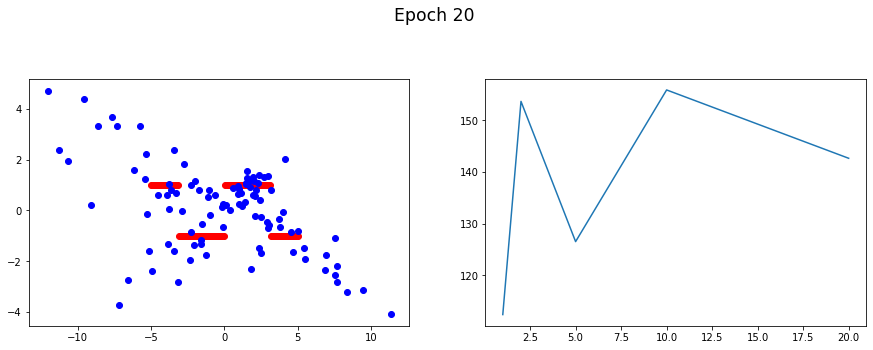

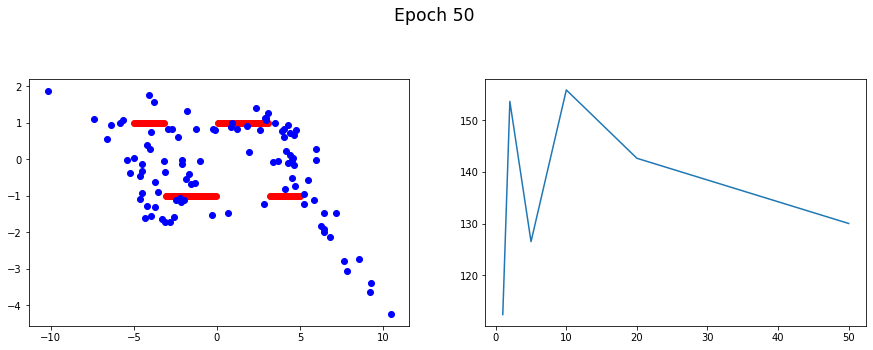

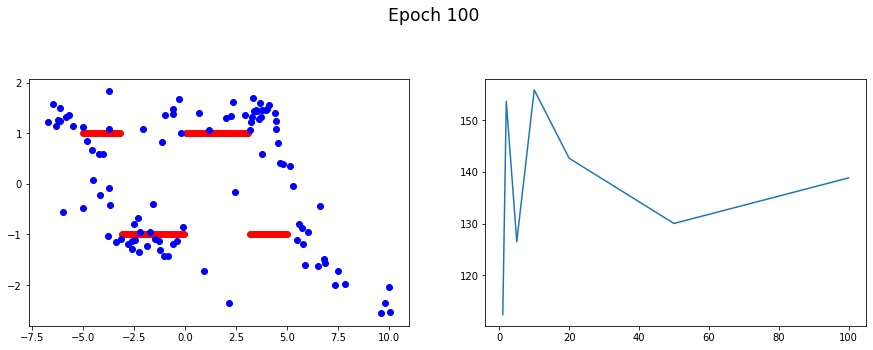

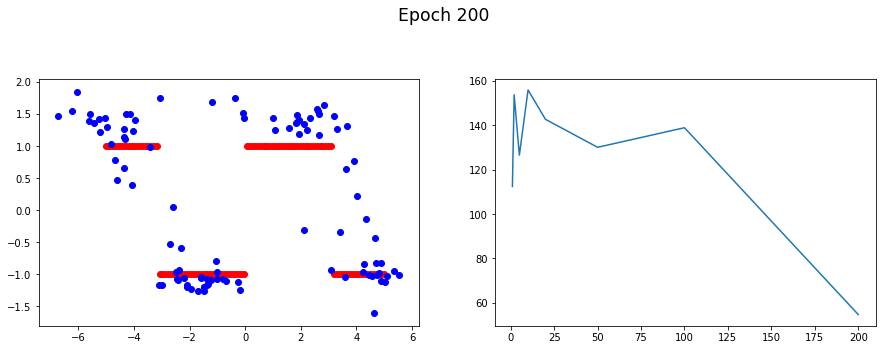

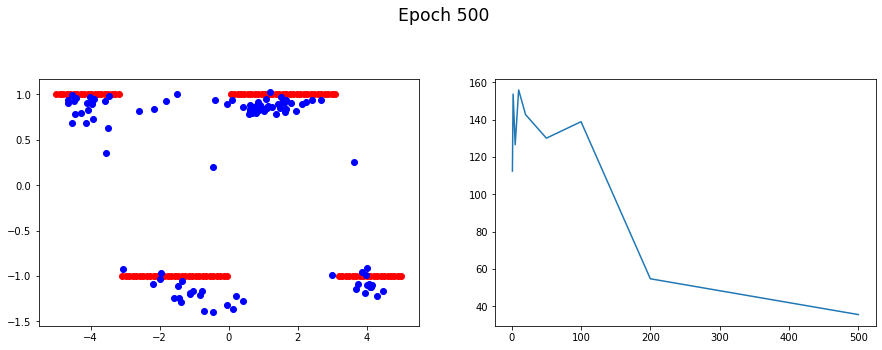

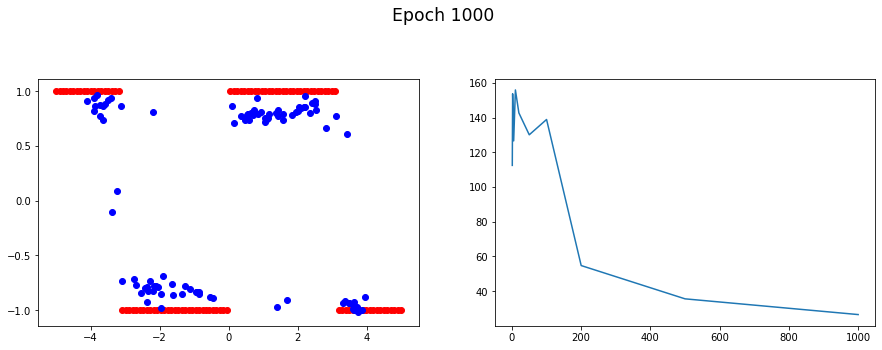

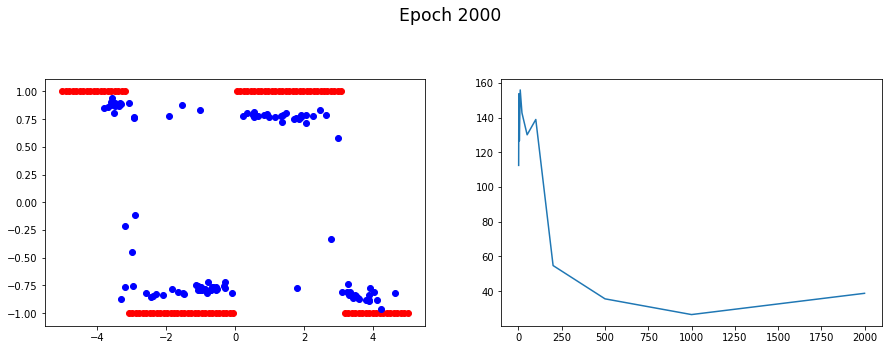

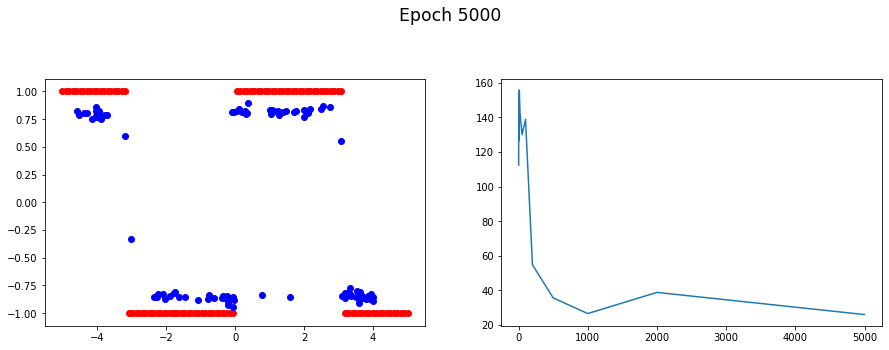

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


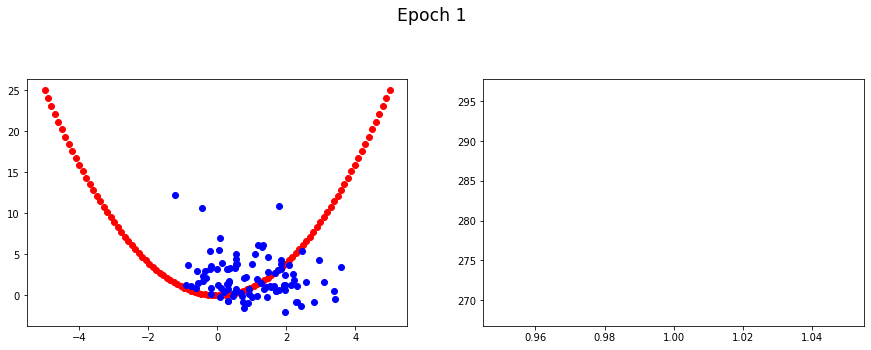

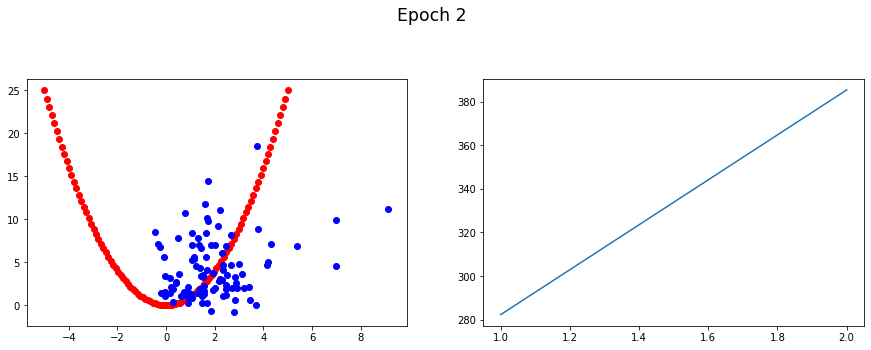

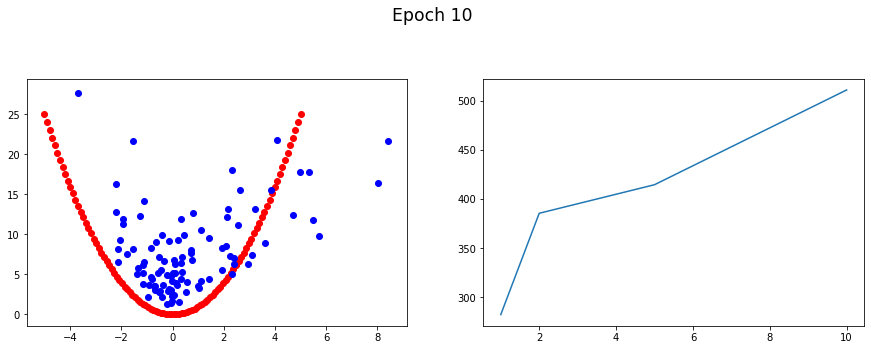

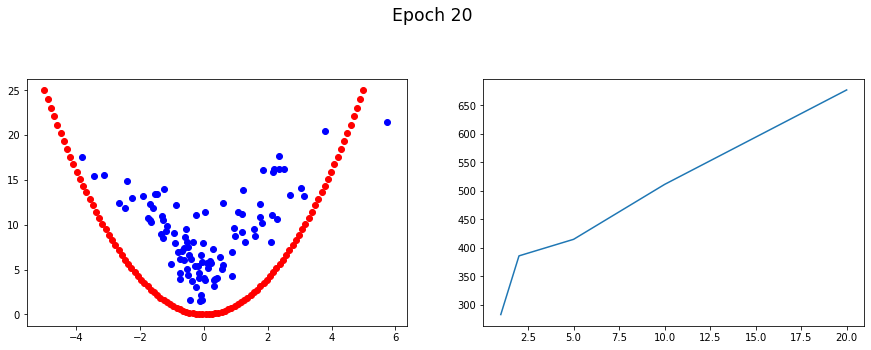

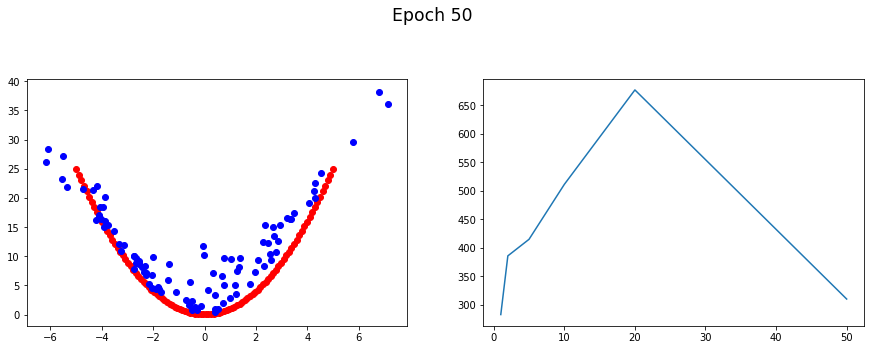

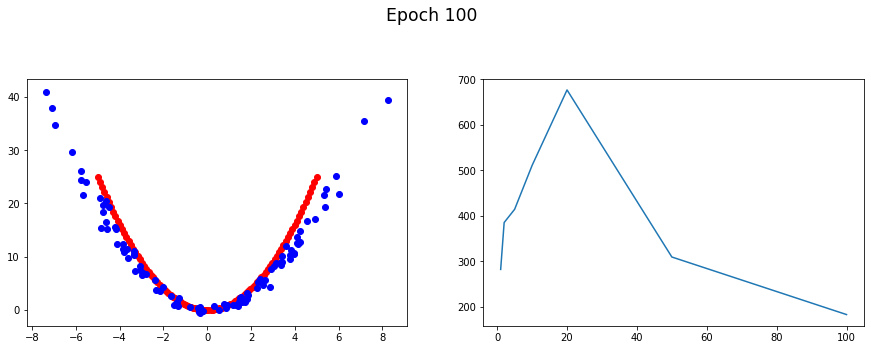

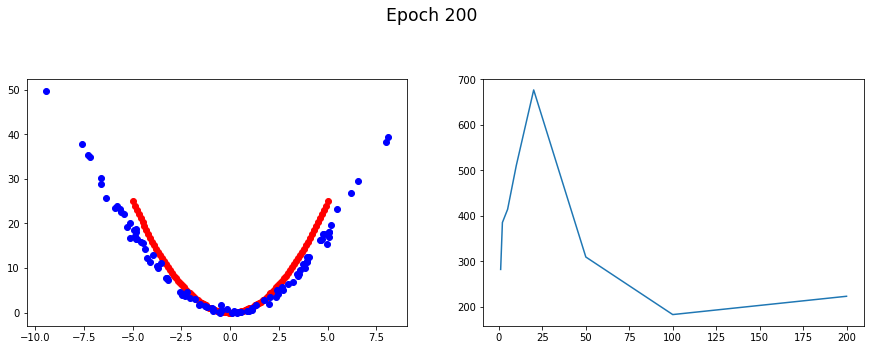

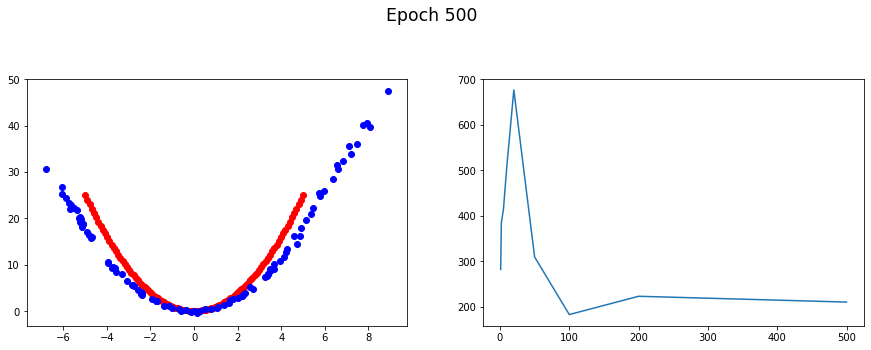

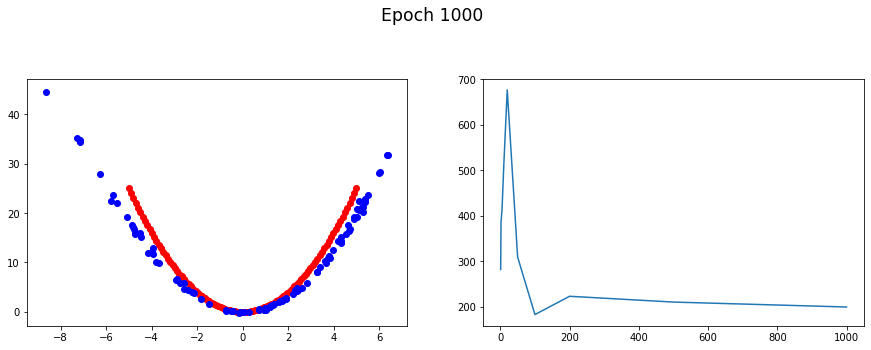

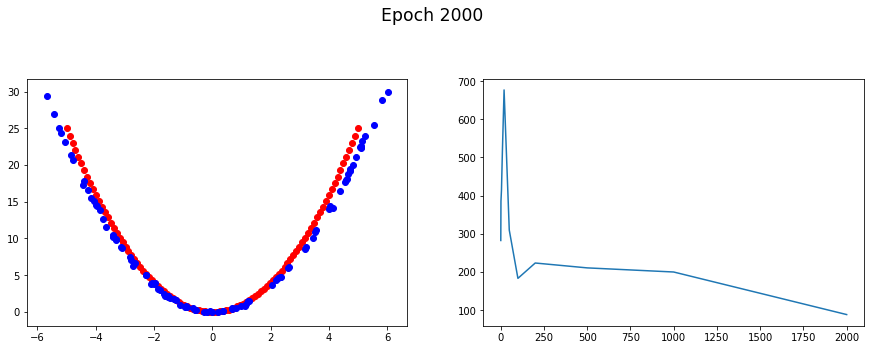

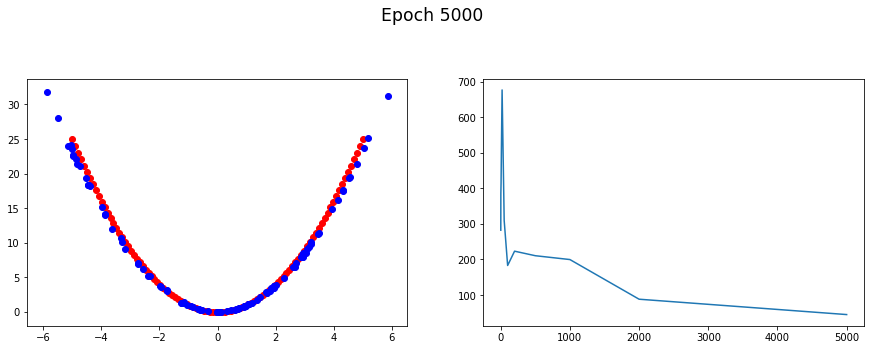

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


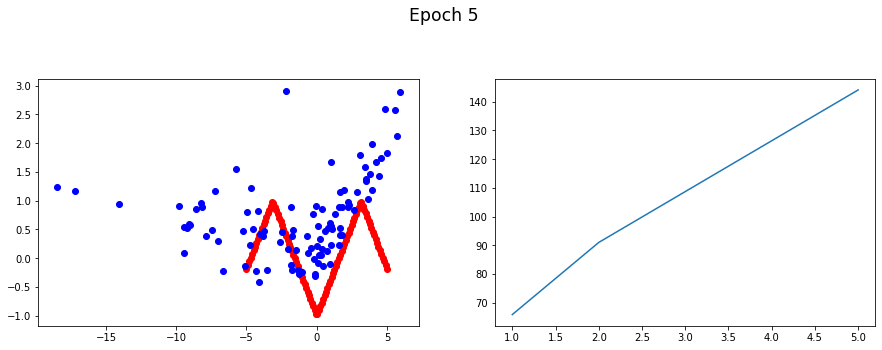

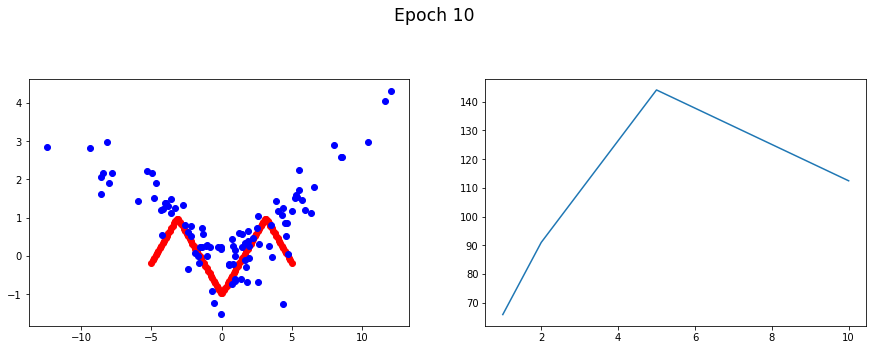

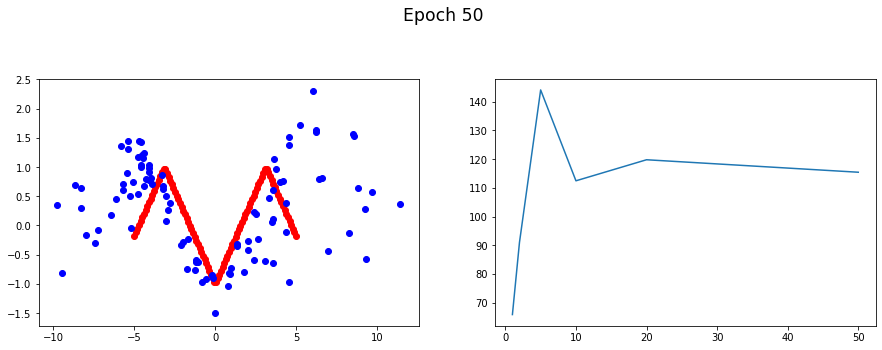

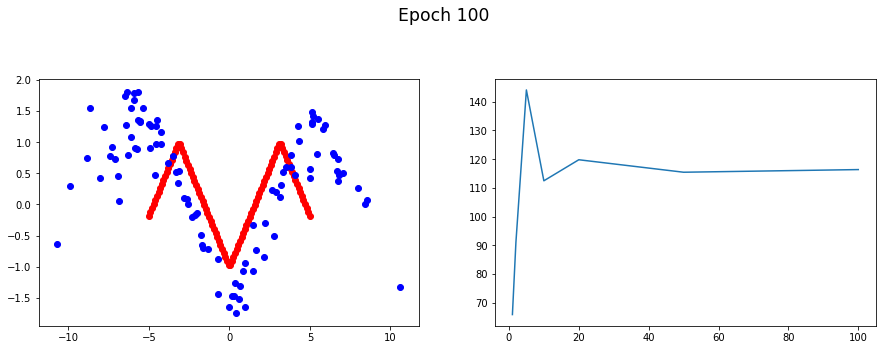

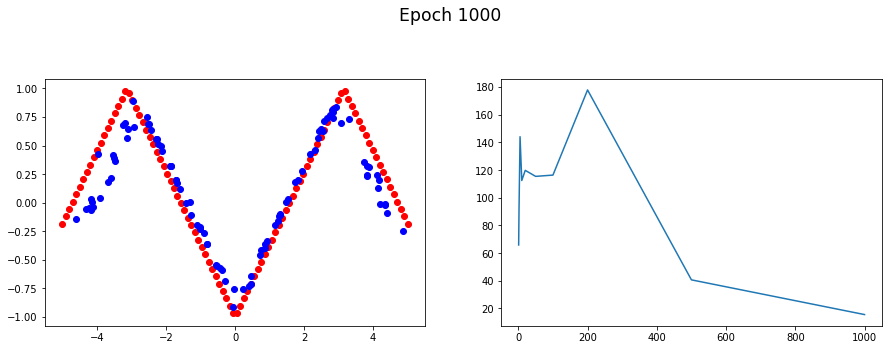

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


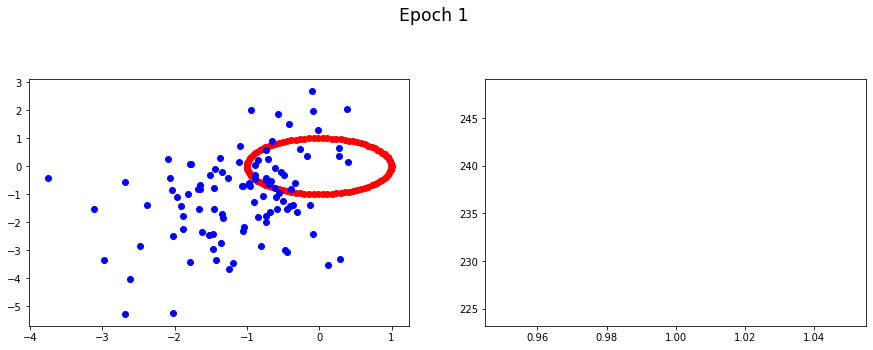

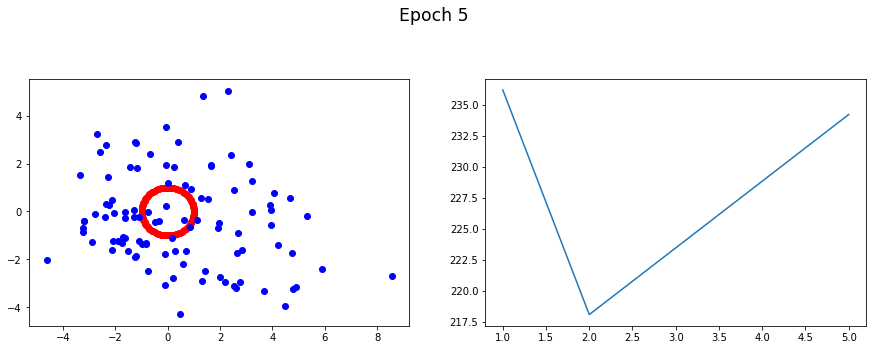

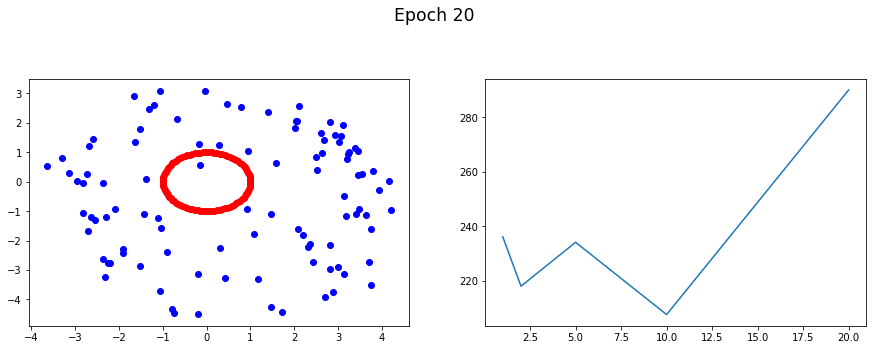

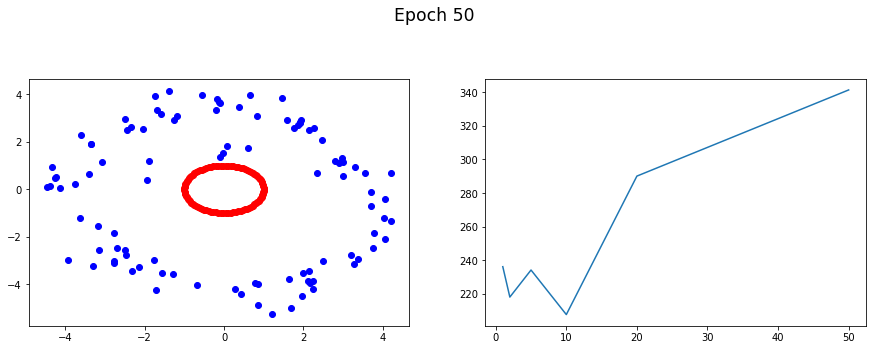

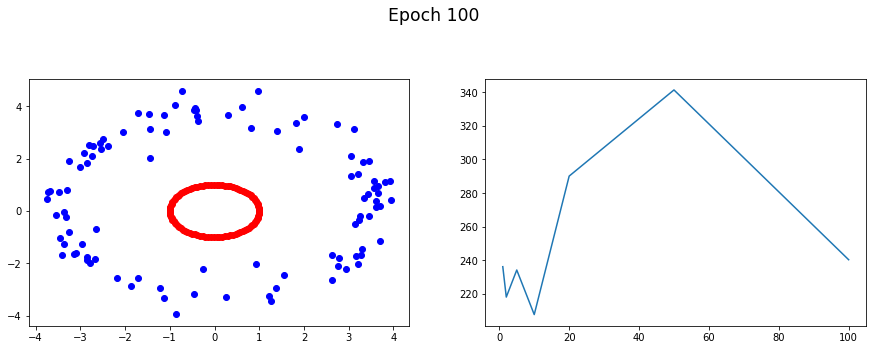

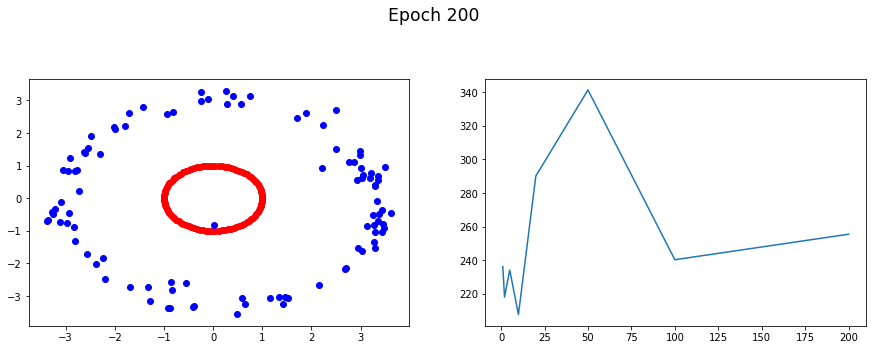

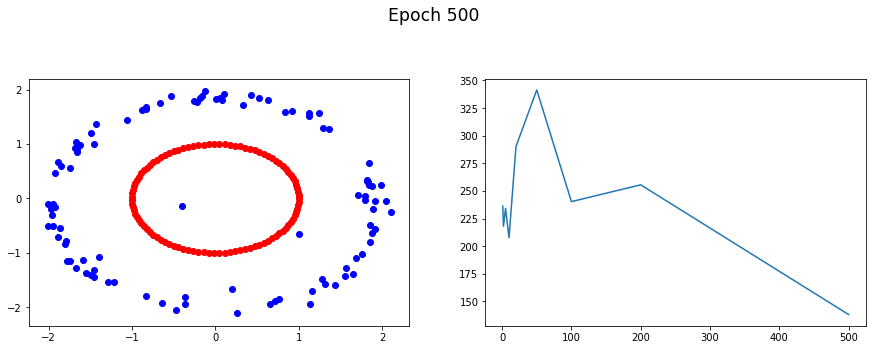

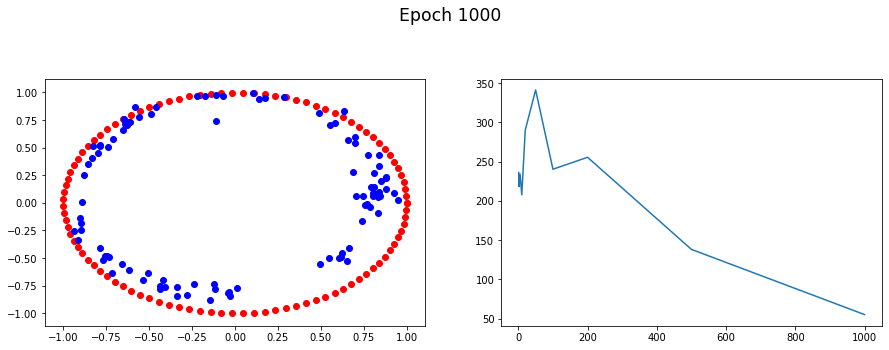

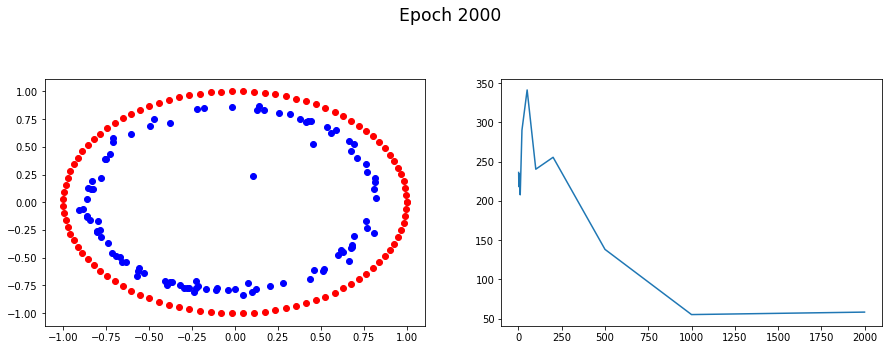

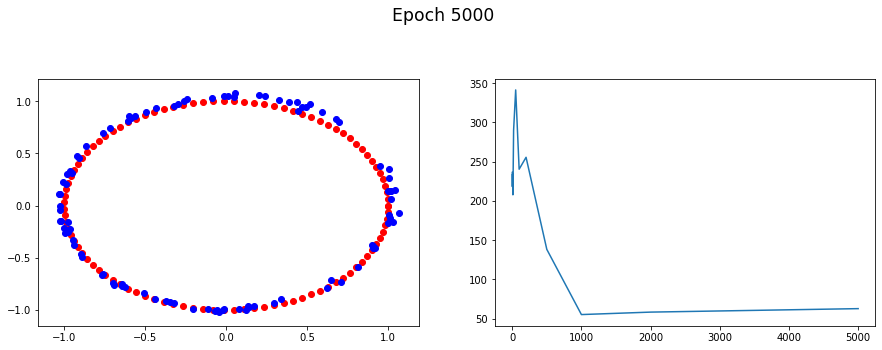

In [0]:
# Cell 4

# this does the real work of training the system.
# you should experiment with effect of changing the n_batch
def train(g_model, d_model, gan_model, latent_dim, function, eval_list, n_epochs=5000, n_batch=200):
    half_batch = int(n_batch / 2)
    epochlist = []
    errorlist = []
    for i in range(n_epochs+1):
        x_real, y_real = generate_real_1D(half_batch, function)
        x_fake, y_fake = generate_fake_1D(g_model, latent_dim, half_batch)
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)
        if i in eval_list:
            error, ax2, fig = summarize_performance(g_model, latent_dim, 100, function)
#            print("Error:", error)
            epochlist.append(i)
            errorlist.append(error)
            ax2.plot(epochlist, errorlist)
            fig.suptitle("Epoch "+str(i), fontsize = "xx-large")
            plt.show()

# in experimenting with this, the size of the latent_dim doesn't seem to matter much
latent_dim = 10
n_epochs = 5000
eval_list = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000]
for function in range (1, 6):
    # Note that we must re-create the generator and discriminator, 
    # else it will already be trained on the prior function
    # you can move the follwing 3 lines to before the 'for function ...' line
    # and see that it will start at epoch 1 with the prior function
    discriminator = create_discriminator()
    generator = create_generator(latent_dim)
    gan_model = create_GAN(generator, discriminator)
    train(generator, discriminator, gan_model, latent_dim, function, eval_list, n_epochs = n_epochs)

Please experiement with changing the range (X and Y) of the patterns. Note that the GAN learns not only the 'function' but also the range, so changing the range will mean the GAN has to start learning a new pattern. 
#### Extra credit
Create a pattern that is mostly based on a random function, but something distinctive enough that you can see if it works (e.g. random dots in a checkerboard pattern or along a line.)

# Generating Medical Images
Here we generate MR images--or at least with enough training time it will learn how to make them. To get good results will require perhaps 100 epochs, which can be more than an hour. We will settle for 'pretty good' in 5-10 minutes.

In [0]:
# Cell 5
####################################     Part 2  Make an image     ###########################################
# we will use  brain MRIs as examples to try to generate new ones



!rm -rf images
!mkdir images
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=19SuwH3NbFweutkFpa3W7tieF351yvDRM' -O ./S1-4.zip
!cd images; unzip -q "../S1-4.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kE8dqVUBwUuyh3ZSj5h2cPZqJMj0G6P2' -O ./S5-8.zip
!cd images; unzip -q "../S5-8.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1f5ncqzCVNugrRppzxqKuwqz1WxETszUP' -O ./S9-12.zip
!cd images; unzip -q "../S9-12.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1raVoqd6Egfy3C0Hw4m-gL0Aw3wNEzcKd' -O ./S13-16.zip
!cd images; unzip -q "../S13-16.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=12yk9kJzY-8T68cvkes_YtKsBfjwk4WYk' -O ./Bet-n-dcm2nii.zip
!unzip -q ./Bet-n-dcm2nii.zip

!rm -rf tmp
!mkdir tmp

MIN_MR = 20

def rescale_5_95_percentile(image):
    dims = np.shape(image)
    image_1d = image.reshape(1, image.size)
    above = np.where(image_1d>MIN_MR, image_1d, image_1d)
    if above.size < image_1d.size/2:
        above = image_1d # avoid bad MIN_MR thresholds
    sorted_im = np.sort(above, axis = None)
    start = int(sorted_im.size / 20)  # 20 = 5%
    end = int(sorted_im.size * 19 / 20) # 95%
    start_val = sorted_im[start]
    end_val = sorted_im[end]
    
    image = np.maximum(image, start_val) # map values below the end_val to end_val
    image = np.minimum(image, end_val)   # map values above the end_val to end_val
    image = image - start_val # subtract the starting intensity

 #   print ("rescaling range " + str(newmin) + " to " + str(histo[1][index]))
    image = (np.maximum(image, 0) / image.max()) * 255.0
    return image

# creating 3 arrays: 1 for each image type.
# we will load all images of a type into the respective array
# we don't care about keeping subjects separate--we just want examples of each image type

T1 = []
T2 = []
GAD = []

for subj in fnmatch.filter(os.listdir('./images'), 'S*'):
    subj_path = os.path.join('./images', subj)
    print (subj_path)
    series = os.listdir(subj_path)
    series = ['T1', 'T2', 'GAD']
    for ser in series:
        cmd = "./dcm2nii -o tmp %s" % (os.path.join (subj_path, ser))
        os.system(cmd)
        f = fnmatch.filter(os.listdir('./tmp'), '*.nii.gz')
        # now read the nifti file just made and add to the numpy array for the 3 types of images
        
        nii_file = os.path.join('./tmp', f[0])   # this call returns an array, but since we keep deleting, there is only 1
        nifti = nib.load(nii_file)
        nif_header = nifti.header
        img = nifti.get_fdata()
        img = rescale_5_95_percentile(img)# now scale the intensity for each image        
        img = img.astype(np.uint8)  # then convert to 8 bits
        img = np.rot90(img, k=1)    # now must rotate 90 degrees cuz nibabel loads them rotated
        img = img[::2, ::2, :]      # and also cut xdim and ydim in half due to memory limits
        dims = np.shape(img)        # then append them on to the end of the array
        zd = dims[2]
        for z in range(int(zd/4), int(zd * 4 / 5)):  # elim slices at top and bottom
            if 'T1' in ser:
                T1.append(img[:,:,z])
            if 'T2' in ser:
                T2.append(img[:,:,z])
            if 'GAD' in ser:
                GAD.append(img[:,:,z])
            
        cmd = "rm ./tmp/%s" % (f[0])  # delete it when done
        os.system(cmd)

XDim = YDim = 128   #128 works   192 or 256 doesn't
XDim4 = int(XDim / 4)
if (XDim != dims[0]):
    print ("Error: mismatched dimensions: need 128x128 images to work")

--2019-11-25 00:42:44--  https://docs.google.com/uc?export=download&id=19SuwH3NbFweutkFpa3W7tieF351yvDRM
Resolving docs.google.com (docs.google.com)... 108.177.119.100, 108.177.119.138, 108.177.119.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7icp74g47u7luj6akhido3onakp278no/1574640000000/16160187475894979440/*/19SuwH3NbFweutkFpa3W7tieF351yvDRM?e=download [following]
--2019-11-25 00:42:48--  https://doc-0s-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7icp74g47u7luj6akhido3onakp278no/1574640000000/16160187475894979440/*/19SuwH3NbFweutkFpa3W7tieF351yvDRM?e=download
Resolving doc-0s-60-docs.googleusercontent.com (doc-0s-60-docs.googleusercontent.com)... 172.217.218.132, 2a00:1450:4013:c08::84
Connecting to doc-0s-60-docs.googleusercontent.com (doc-0s

# Middle Section: Creating MR Images
In this part, we train a GAN to generate images that are similar to our training set, which are T1-weighted images of the head. Just like with 1D, we have a function to load a random sampling of real images, a generator function that makes images that are supposed to be like the real images, and a discriminator that is trying to tell the difference between the real and generated images.
Feel free to switch your data to the T2 or post-contrast MRIs. The GAN will learn whatever you feed to it!

In [0]:
# Cell 6 . functions to load groups of real images
def load_real_samples():
    # plot images from the training dataset
    # switch this to T2 or GAD if you prefer
    X = T1
#    print (len(X))
#    print (X[0].shape)
    for i in range(4 * 4):
        pyplot.subplot(4, 4, 1 + i)        # define subplot
        pyplot.axis('off')                 # turn off axis
        pyplot.imshow(X[i], cmap='gray')   # plot raw pixel data
    pyplot.show()

    X = expand_dims(X, axis=-1)	# expand to 3d, e.g. add channels
    X = X.astype('float32')	# convert from ints to floats
    X = (X - 127.5) / 127.5 	# scale from [0,255] to [-1,1]
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)	# choose random instances
	X = dataset[ix]	            # select images
	y = ones((n_samples, 1))	# generate class labels--1 for real
	return X, y

In [0]:
# Cell 7   define the standalone discriminator model
def create_discriminator(in_shape=(XDim, YDim,1)):
	model = Sequential()
	# downsample to 32x32
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 16x16
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def create_generator(latent_dim):
	model = Sequential()
	# foundation for quarter on each side image
	n_nodes = 128 * XDim4 * XDim4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((XDim4, XDim4, 128)))
	# upsample
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to original res
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (XDim4,XDim4), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def create_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [0]:
# Cell 8    generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y



In [0]:
# Cell 9  plot images
def plot_n_save(examples, n, cnt):
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray')

    fig = pyplot.gcf()
    fig.set_size_inches(16, 16)
    name = 'GAN_ep_%3d.png' % (cnt)
    fig.savefig(name)
    pyplot.show()

In [0]:
# Cell 10
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=25, n_batch=64): # n_batch was 128 larger # batches means smaller batch size
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
	# manually enumerate epochs
    for i in range(n_epochs):
		# enumerate batches over the training set
        for j in range(bat_per_epo):
			# get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

			# summarize loss on this batch
        if i+1 in [1,2,5,10,20,50,100,200,500,1000,2000,5000]:
            print('Epoch : %d, Losses: discrim real=%.3f, discrim fake=%.3f gan=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
            plot_n_save (X_fake, 4, i)

	# save the generator model
    g_model.save('generator.h5')
    return


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
208
(128, 128)


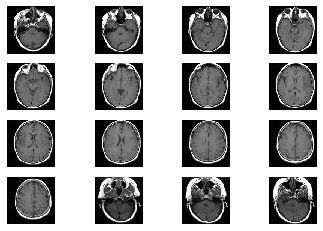

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch : 1, Losses: discrim real=0.129, discrim fake=0.422 gan=1.378


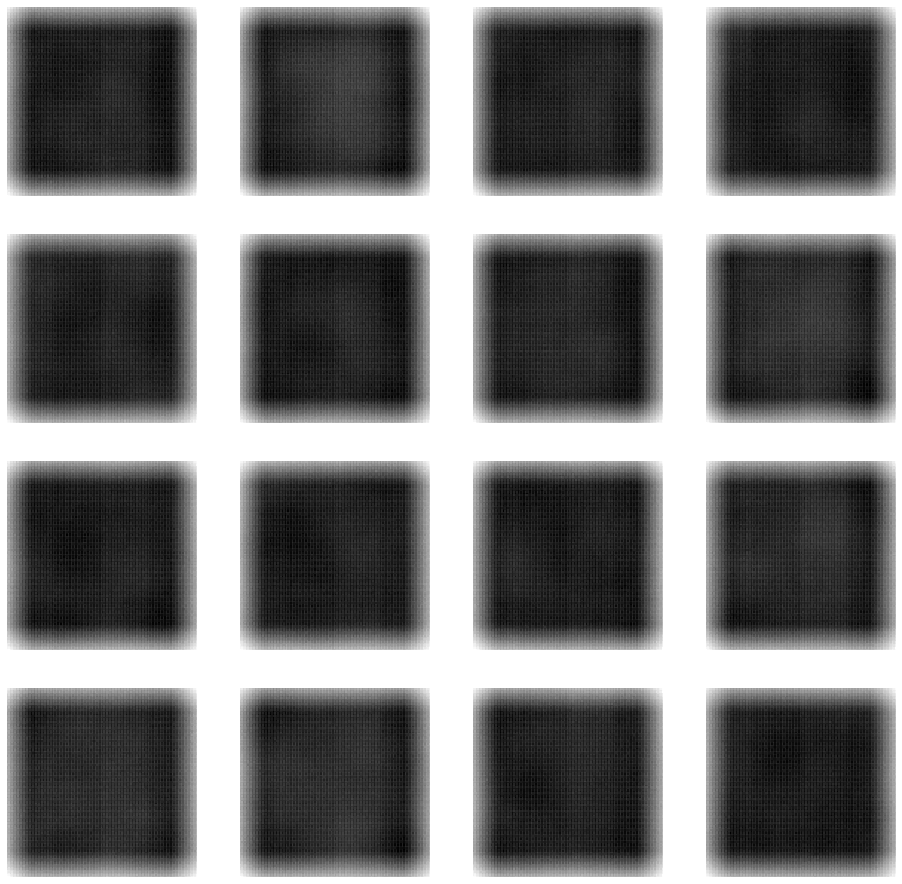

Epoch : 2, Losses: discrim real=0.024, discrim fake=1.326 gan=0.605


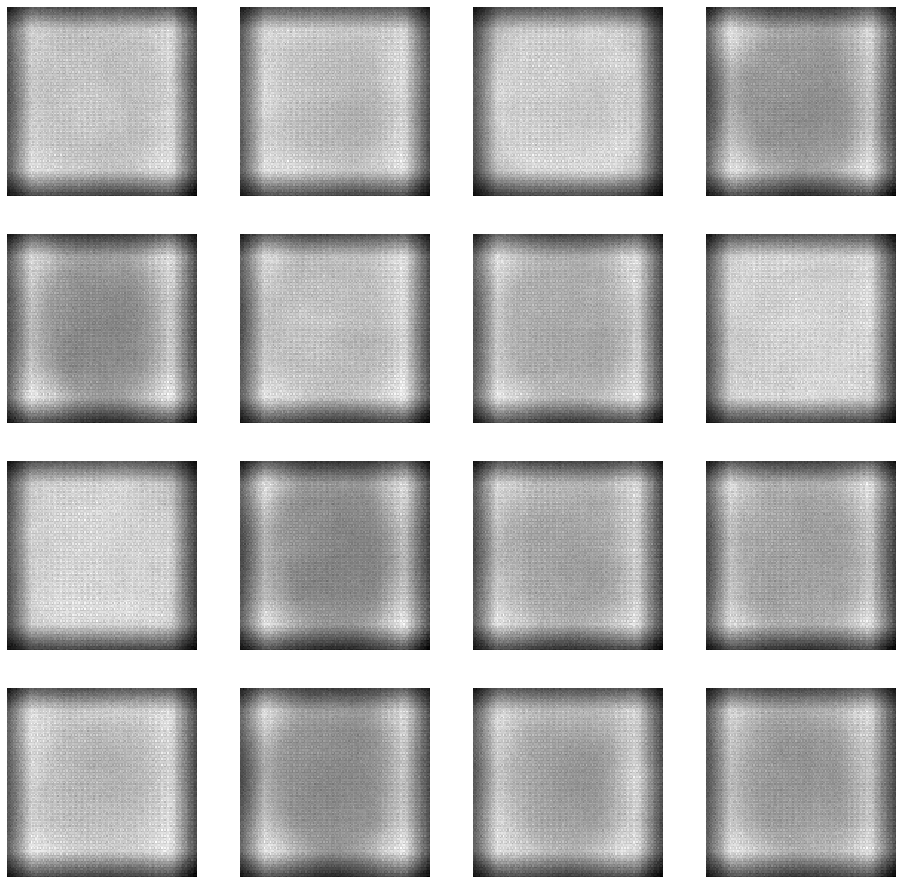

Epoch : 5, Losses: discrim real=0.006, discrim fake=0.345 gan=1.328


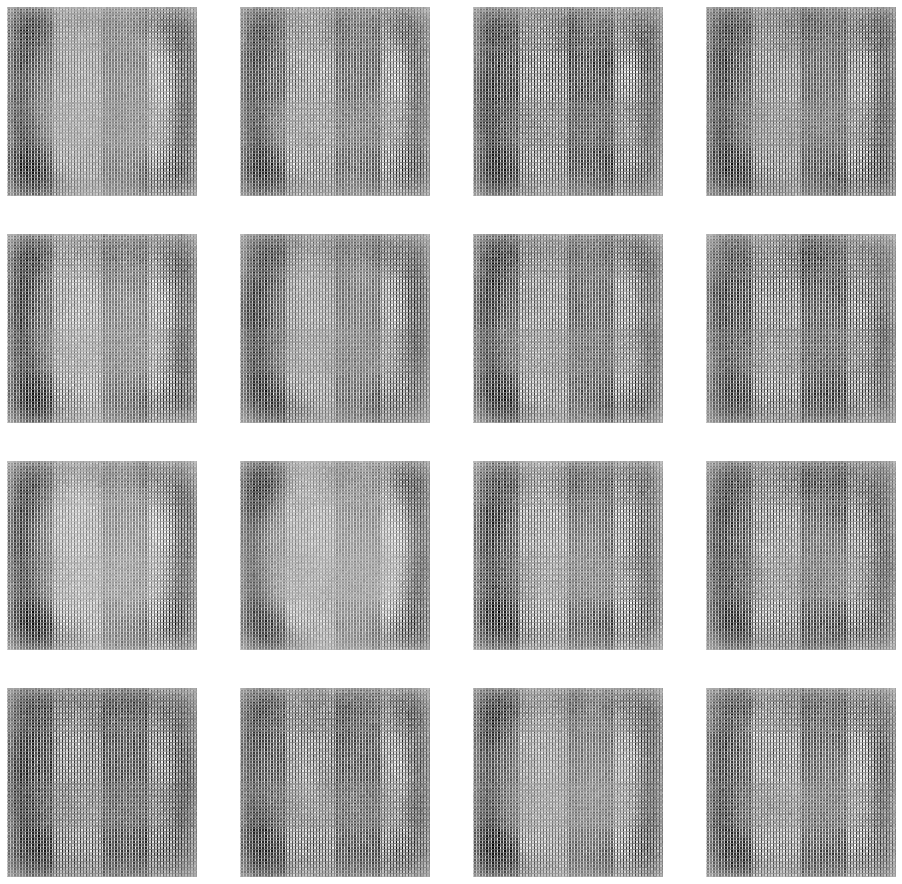

Epoch : 10, Losses: discrim real=0.561, discrim fake=0.724 gan=2.575


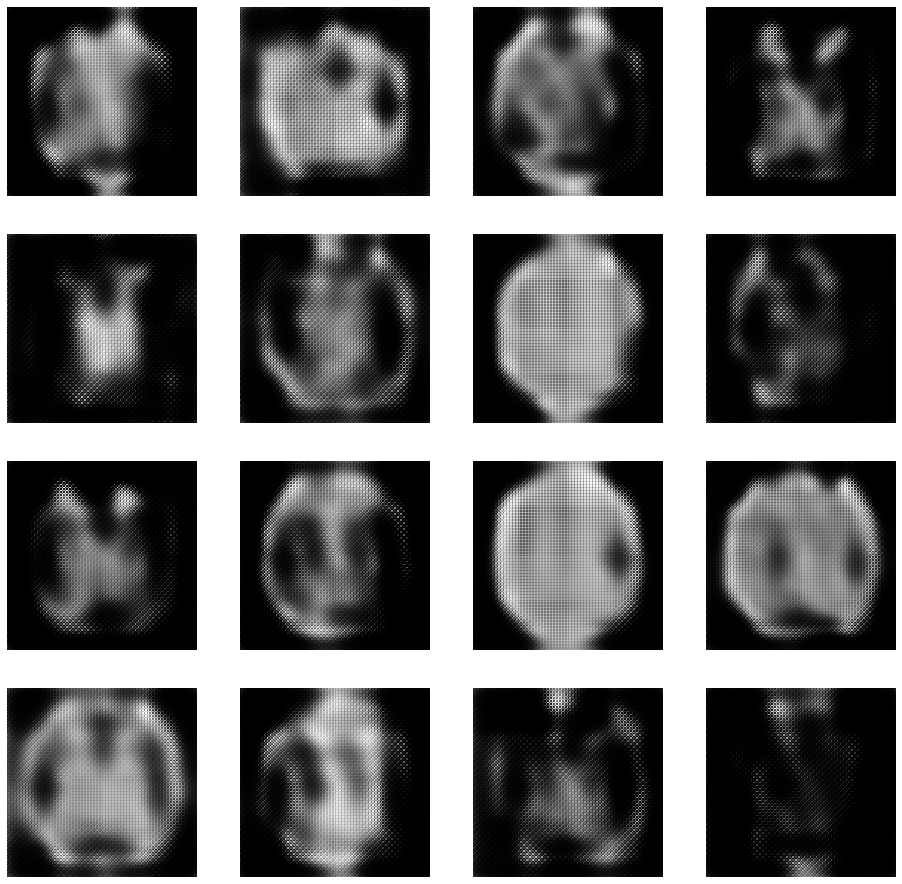

Epoch : 20, Losses: discrim real=0.503, discrim fake=0.643 gan=2.225


Epoch : 50, Losses: discrim real=0.476, discrim fake=0.428 gan=1.497


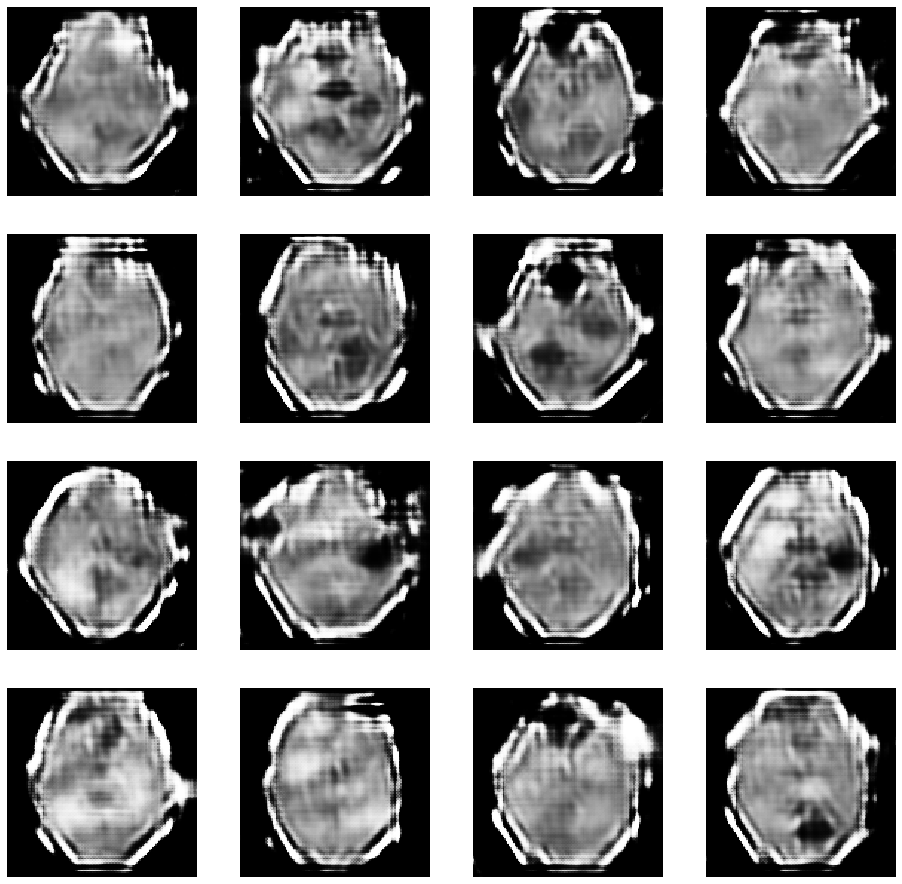

Epoch : 100, Losses: discrim real=0.706, discrim fake=0.582 gan=1.259


Epoch : 200, Losses: discrim real=0.553, discrim fake=0.640 gan=1.351
Epoch : 500, Losses: discrim real=0.664, discrim fake=0.489 gan=1.731


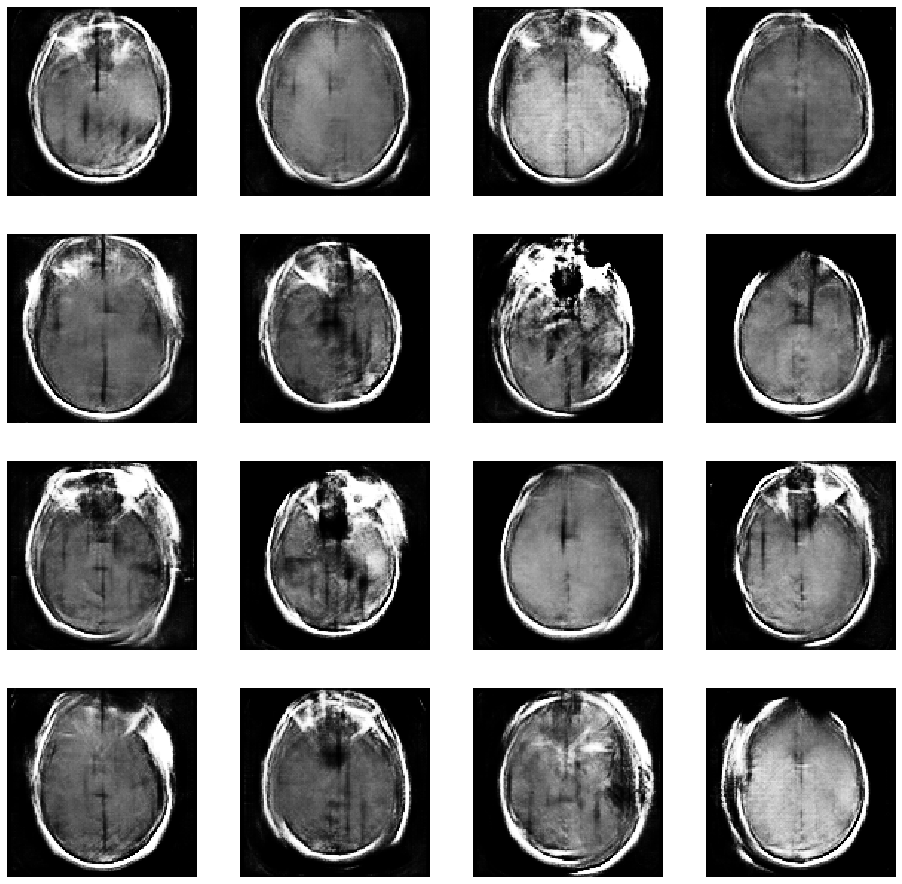

Epoch : 1000, Losses: discrim real=0.292, discrim fake=0.611 gan=2.009


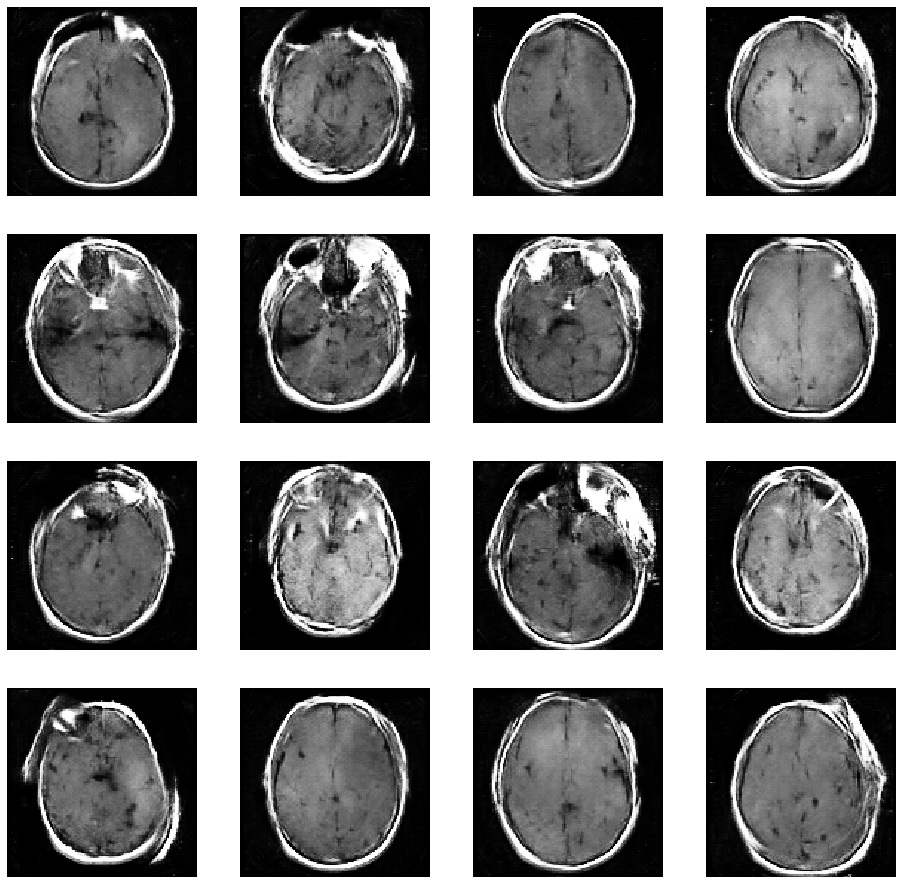

In [0]:
# Cell 11
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = create_discriminator()
# create the generator
generator = create_generator(latent_dim)
# create the gan
gan_model = create_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs = 1001, n_batch=32)

# Final Section: Style Transfer using Pix2Pix
###This notebook comes almost entirely from the [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix) with only minor changes. The dataset was created from the [Brain-Development.org IXI Dataset](https://brain-development.org/ixi-dataset/).

## Load the dataset
* Because we have just 1 image to transfer from, we use 'image jittering to create many parts of that image
* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [0]:
# Cell 13

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mqgBKTB0MtGf8Fhc8HaedJyiD8yMoXOh' -O ./MedNIST.zip


BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [0]:
# Cell 14

def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image, channels=3)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [0]:
# Cell 15

# Load and show a sample input(inp) and real/target(re)
# inp and re will be used later on for further visualization

inp, re = load(PATH+'train/IXI041-Guys-0706_img-5_slice-150.png')

# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [0]:
# Cell 16  Augmentation

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [0]:
# Cell 17
# this shows what random jittering is doing

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [0]:
# Cell 18 . Loader functions

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [0]:
# Cell 19  Input Pipeline functions

# Train
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Test
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
# Cell 20  Build the generator over the next cells

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

In [0]:
# Cell 21

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

In [0]:
# Cell 22

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
# Cell 23

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

* **Generator loss**
  * We use a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is the mean absolute error between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

In [0]:
# Cell 19
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [0]:
# Cell 20

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [0]:
# Cell 21

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)

## Define the Optimizers and Checkpoint-saver

In [0]:
# Cell 22

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)


In [0]:
# Cell 23

def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard (if you enabled at start)

In [0]:
# Cell 24
EPOCHS = 300

import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [0]:
# Cell 25

def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:
```
%load_ext tensorboard
%tensorboard --logdir {log_dir}
```

Now run the training loop:

In [0]:
# Cell 26

fit(train_dataset, EPOCHS, test_dataset)


In [0]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)